In [7]:
import os
import logging
import rasterio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from geotiff import GeoTiff
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split

### Env Config

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.get_logger().setLevel('ERROR')

In [9]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Dataset

In [ ]:
def load_geotiff(file_path):
    """Load and preprocess a GeoTIFF file using rasterio instead of geotiff package"""
    try:
        with rasterio.open(file_path) as src:
            array = src.read()
            
            nodata = src.nodata or 32767  # Use 32767 as default nodata value
            
            array = array.astype(np.float32)
            
            array[array == nodata] = 0
            
            array = np.transpose(array, (1, 2, 0))
            
            # Split into image and mask
            image = array[:, :, :3]
            mask = array[:, :, 3:4]  # Keep the mask as (H,W,1)
            
            # Normalize
            image = image / 255.0
            image = np.clip(image, 0, 1)
            
            mask = (mask > 0).astype(np.float32)
            
            if not np.any(mask):
                return None, None
            
            return image, mask
            
    except Exception as e:
        logger.error(f"Error processing {file_path}: {str(e)}")
        return None, None

def prepare_dataset(data_dir, image_size=(128, 128)):
    """Prepare dataset for training"""
    images = []
    masks = []
    file_paths = []
    data_dir = Path(data_dir)
    logger.info(f"Looking for TIF files in: {data_dir}")
    
    tif_files = list(data_dir.glob('**/*.[Tt][Ii][Ff]')) + \
                list(data_dir.glob('**/*.[Tt][Ii][Ff][Ff]'))
    
    logger.info(f"Found {len(tif_files)} TIF files")
    
    for i, file_path in enumerate(tif_files):
        if i % 100 == 0:
            logger.info(f"Processing file {i+1}/{len(tif_files)}")
            
        img, mask = load_geotiff(str(file_path))
        if img is not None and mask is not None:
            img = tf.image.resize(img, image_size)
            mask = tf.image.resize(mask, image_size, method='nearest')
            
            img = tf.cast(img, tf.float32)
            mask = tf.cast(mask, tf.float32)
            
            images.append(img)
            masks.append(mask)
            file_paths.append(file_path)
    
    if not images:
        raise ValueError(f"No valid images found in {data_dir}")
    
    images_array = np.array(images)
    masks_array = np.array(masks)
    
    logger.info(f"Final dataset shape: {images_array.shape}, masks shape: {masks_array.shape}")
    logger.info(f"Number of images with masks: {len(images)}")
    
    return images_array, masks_array, file_paths

def visualize_samples(images, file_paths, title, num_samples=16, save_path='/app/plots/'):
    plt.close('all')
    
    rows = int(np.sqrt(num_samples))
    cols = int(np.ceil(num_samples / rows))

    fig = plt.figure(figsize=(20, 20))
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        
        img = images[idx]
        filename = Path(file_paths[idx]).name
        
        mean_val = np.mean(img)
        std_val = np.std(img)
        min_val = np.min(img)
        max_val = np.max(img)
        
        plt.imshow(img)
        plt.title(f'Title: {title}\n' +
                f'File: {filename}\n' + 
                 f'Range: [{min_val:.3f}, {max_val:.3f}]')
        plt.axis('off')
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
IMAGE_SIZE = (128, 128)
logger.info("Loading dataset...")
X, y, file_paths = prepare_dataset('/app/data', IMAGE_SIZE)

### Dataset Analysis

In [ ]:
def visualize_samples_with_masks(images, masks, file_paths, num_samples=16, save_path=None):
    plt.close('all')
    
    rows = num_samples
    cols = 2
    
    fig = plt.figure(figsize=(15, 4*num_samples))
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Original 
        plt.subplot(rows, cols, 2*i + 1)
        img = images[idx]
        filename = Path(file_paths[idx]).name
        
        plt.imshow(img)
        plt.title(f'Image: {filename}\n' + 
                 f'Mean: {np.mean(img):.3f}, Std: {np.std(img):.3f}')
        plt.axis('off')
        
        # Mask
        plt.subplot(rows, cols, 2*i + 2)
        mask = masks[idx]
        
        plt.imshow(mask[..., 0], cmap='gray')
        plt.title(f'Mask\n' + 
                 f'Positive pixels: {np.sum(mask > 0)}\n' +
                 f'Coverage: {100 * np.mean(mask):.2f}%')
        plt.axis('off')
    
    plt.tight_layout()
    
    plt.show()
    
def analyze_dataset(images, masks, file_paths):
    logger.info("\nDataset Analysis:")
    logger.info(f"Total number of images: {len(images)}")
    logger.info(f"Image shape: {images[0].shape}")
    logger.info(f"Mask shape: {masks[0].shape}")
    
    mask_coverage = np.mean(masks, axis=(1,2,3))
    
    logger.info("\nMask statistics:")
    logger.info(f"Average mask coverage: {100 * np.mean(mask_coverage):.2f}%")
    logger.info(f"Min coverage: {100 * np.min(mask_coverage):.2f}%")
    logger.info(f"Max coverage: {100 * np.max(mask_coverage):.2f}%")
    
    # Calculate statistics per channel
    means = np.mean(images, axis=(1, 2))
    stds = np.std(images, axis=(1, 2))
    mins = np.min(images, axis=(1, 2))
    maxs = np.max(images, axis=(1, 2))
    
    logger.info("\nPer-channel statistics:")
    for i in range(3):
        logger.info(f"Channel {i}:")
        logger.info(f"  Mean: {np.mean(means[:, i]):.3f} ± {np.std(means[:, i]):.3f}")
        logger.info(f"  Std:  {np.mean(stds[:, i]):.3f} ± {np.std(stds[:, i]):.3f}")
        logger.info(f"  Range: [{np.mean(mins[:, i]):.3f}, {np.mean(maxs[:, i]):.3f}]")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.hist(mask_coverage * 100, bins=50)
    plt.title('Distribution of Mask Coverage')
    plt.xlabel('Coverage (%)')
    plt.ylabel('Count')
    
    plt.subplot(132)
    plt.hist(np.mean(means, axis=1), bins=50)
    plt.title('Distribution of Mean Image Values')
    plt.xlabel('Mean Pixel Value')
    plt.ylabel('Count')
    
    plt.subplot(133)
    plt.hist(np.mean(stds, axis=1), bins=50)
    plt.title('Distribution of Image Std Dev')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('dataset_statistics.png')
    plt.close()
    
    high_coverage = np.argsort(mask_coverage)[-5:]
    low_coverage = np.argsort(mask_coverage)[:5]
    
    logger.info("\nSamples with highest mask coverage:")
    for idx in high_coverage:
        logger.info(f"File: {file_paths[idx].name}, " + 
                   f"Coverage: {100 * mask_coverage[idx]:.2f}%")
    
    logger.info("\nSamples with lowest mask coverage:")
    for idx in low_coverage:
        logger.info(f"File: {file_paths[idx].name}, " + 
                   f"Coverage: {100 * mask_coverage[idx]:.2f}%")
    
    return np.concatenate([high_coverage, low_coverage])

INFO:__main__:
Dataset Analysis:
INFO:__main__:Total number of images: 3482
INFO:__main__:Image shape: (128, 128, 3)
INFO:__main__:Mask shape: (128, 128, 1)
INFO:__main__:
Mask statistics:
INFO:__main__:Average mask coverage: 2.65%
INFO:__main__:Min coverage: 0.00%
INFO:__main__:Max coverage: 17.94%
INFO:__main__:
Per-channel statistics:
INFO:__main__:Channel 0:
INFO:__main__:  Mean: 0.344 ± 0.132
INFO:__main__:  Std:  0.260 ± 0.050
INFO:__main__:  Range: [0.001, 0.971]
INFO:__main__:Channel 1:
INFO:__main__:  Mean: 0.323 ± 0.123
INFO:__main__:  Std:  0.244 ± 0.046
INFO:__main__:  Range: [0.002, 0.952]
INFO:__main__:Channel 2:
INFO:__main__:  Mean: 0.235 ± 0.092
INFO:__main__:  Std:  0.192 ± 0.034
INFO:__main__:  Range: [0.002, 0.888]
INFO:__main__:
Samples with highest mask coverage:
INFO:__main__:File: image14426.TIF, Coverage: 17.16%
INFO:__main__:File: image14265.TIF, Coverage: 17.32%
INFO:__main__:File: image14423.TIF, Coverage: 17.50%
INFO:__main__:File: image14421.TIF, Coverage:

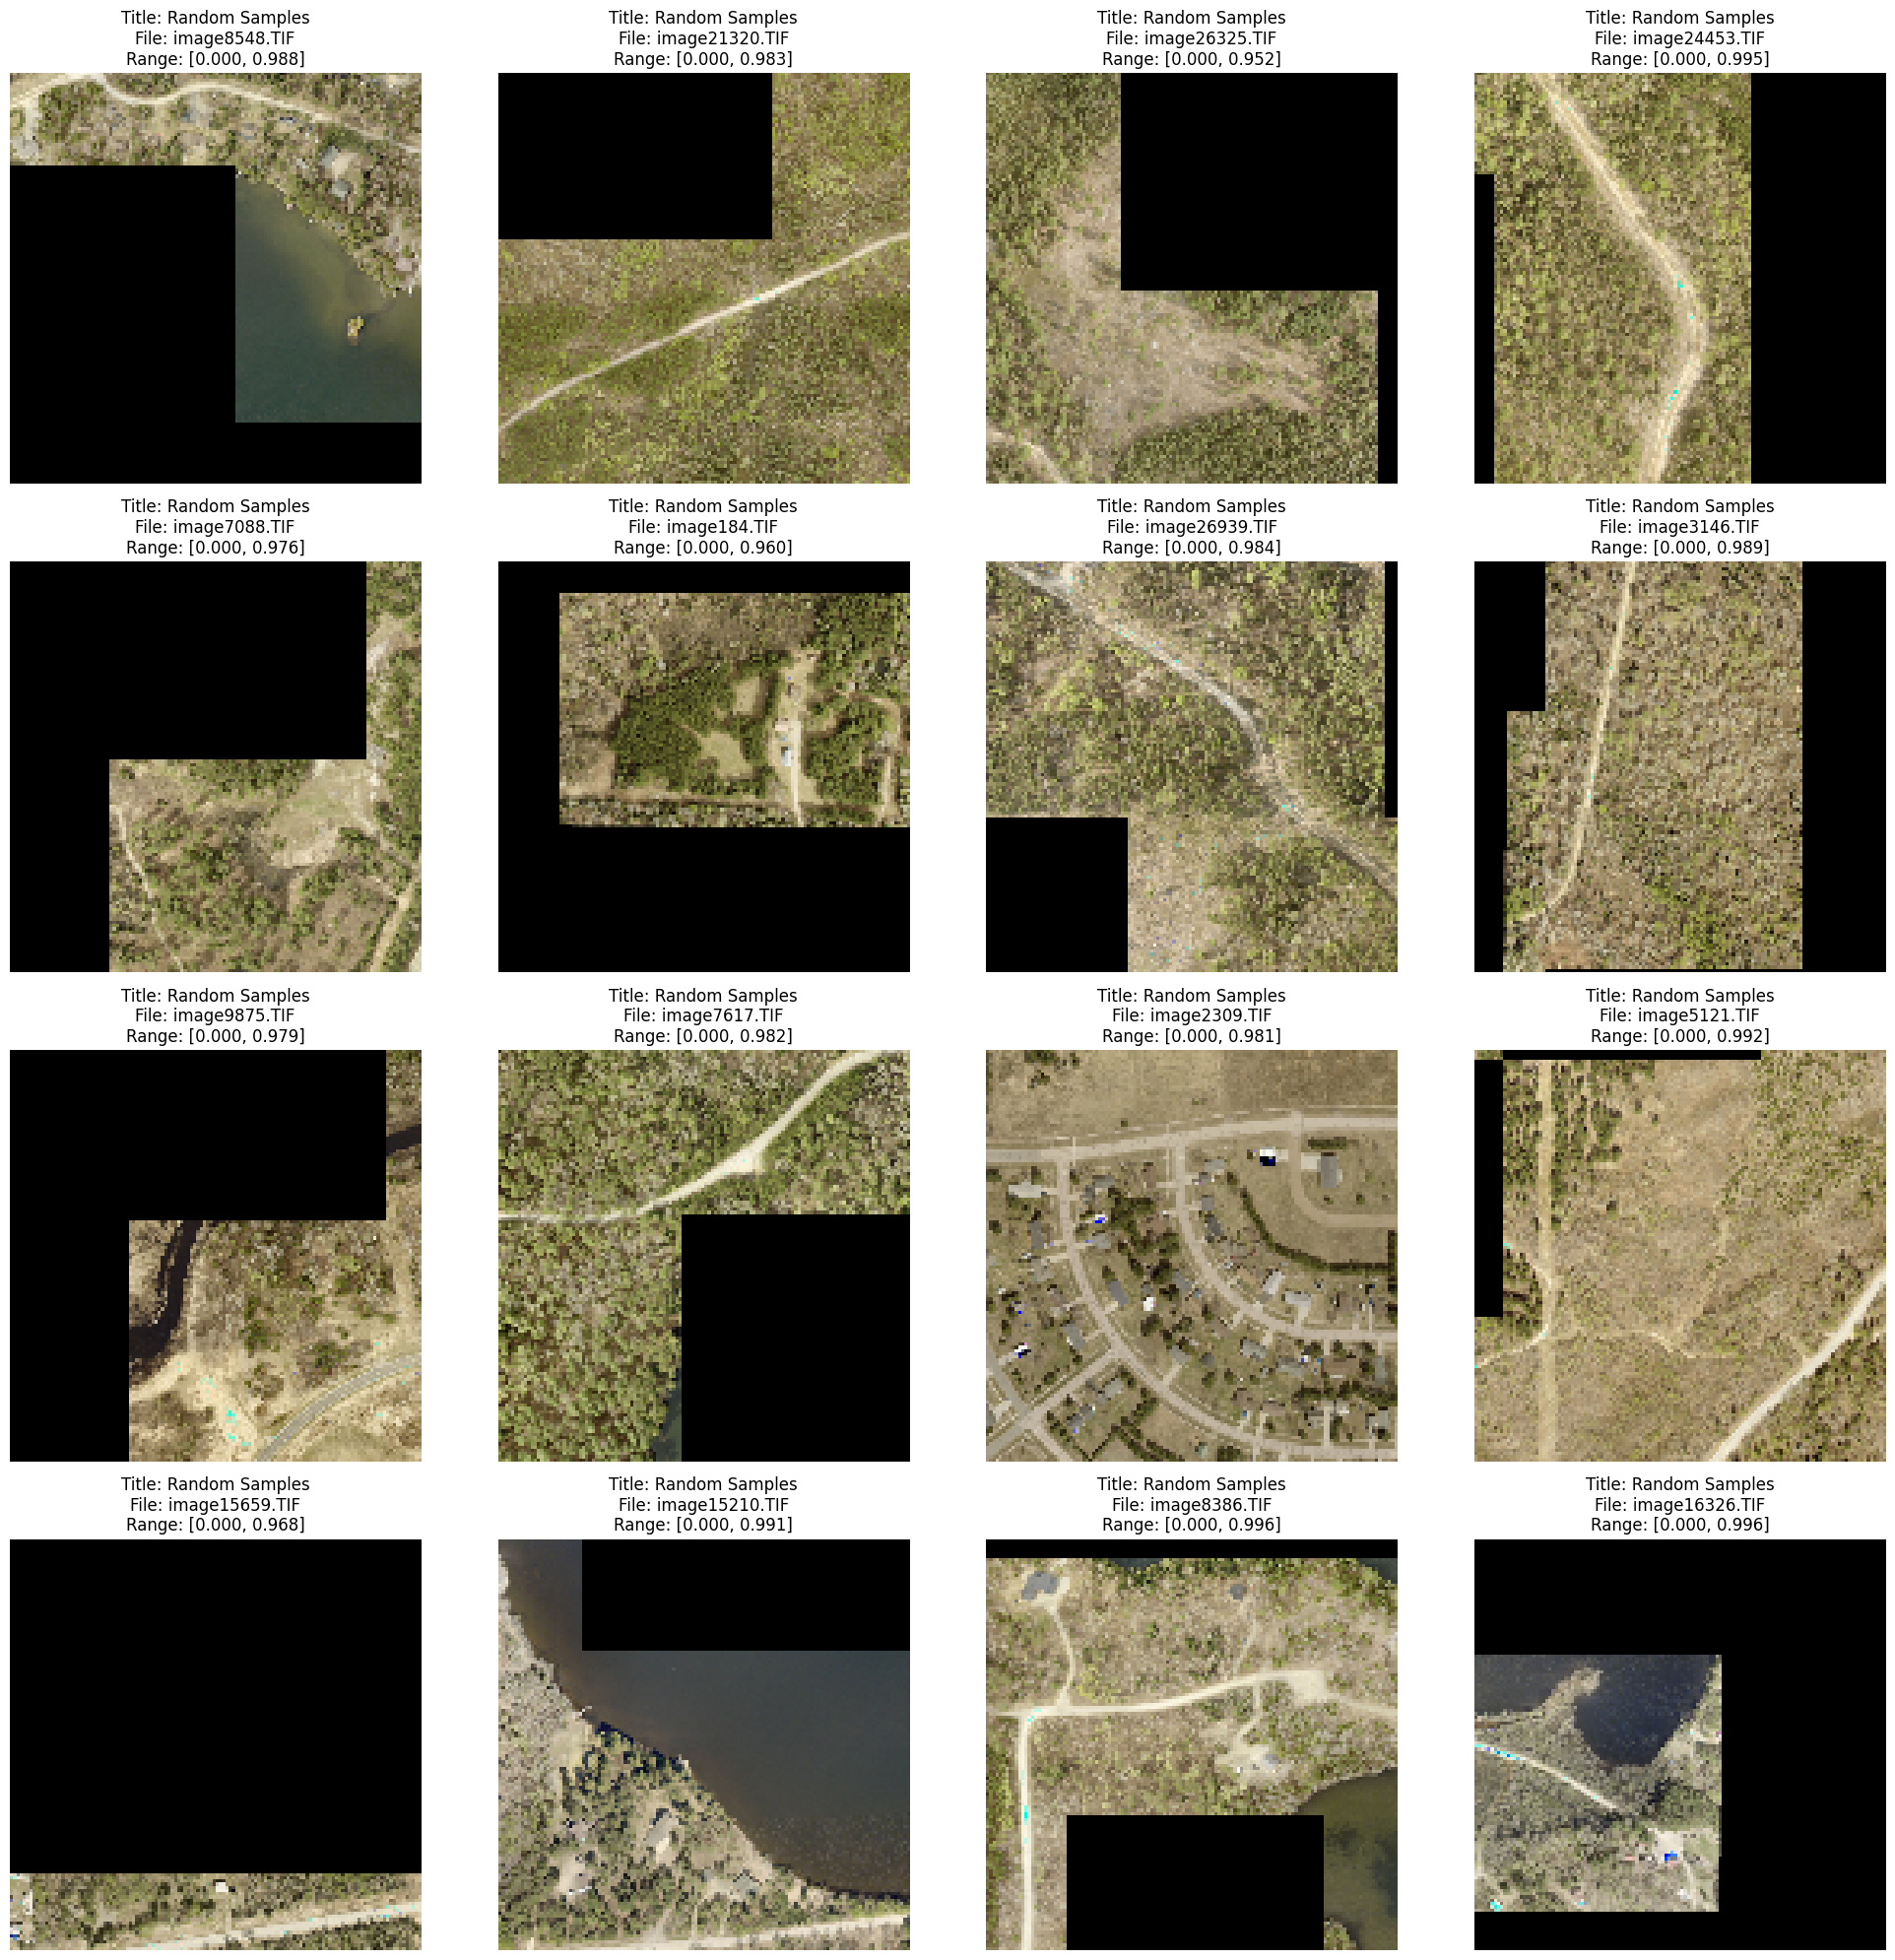

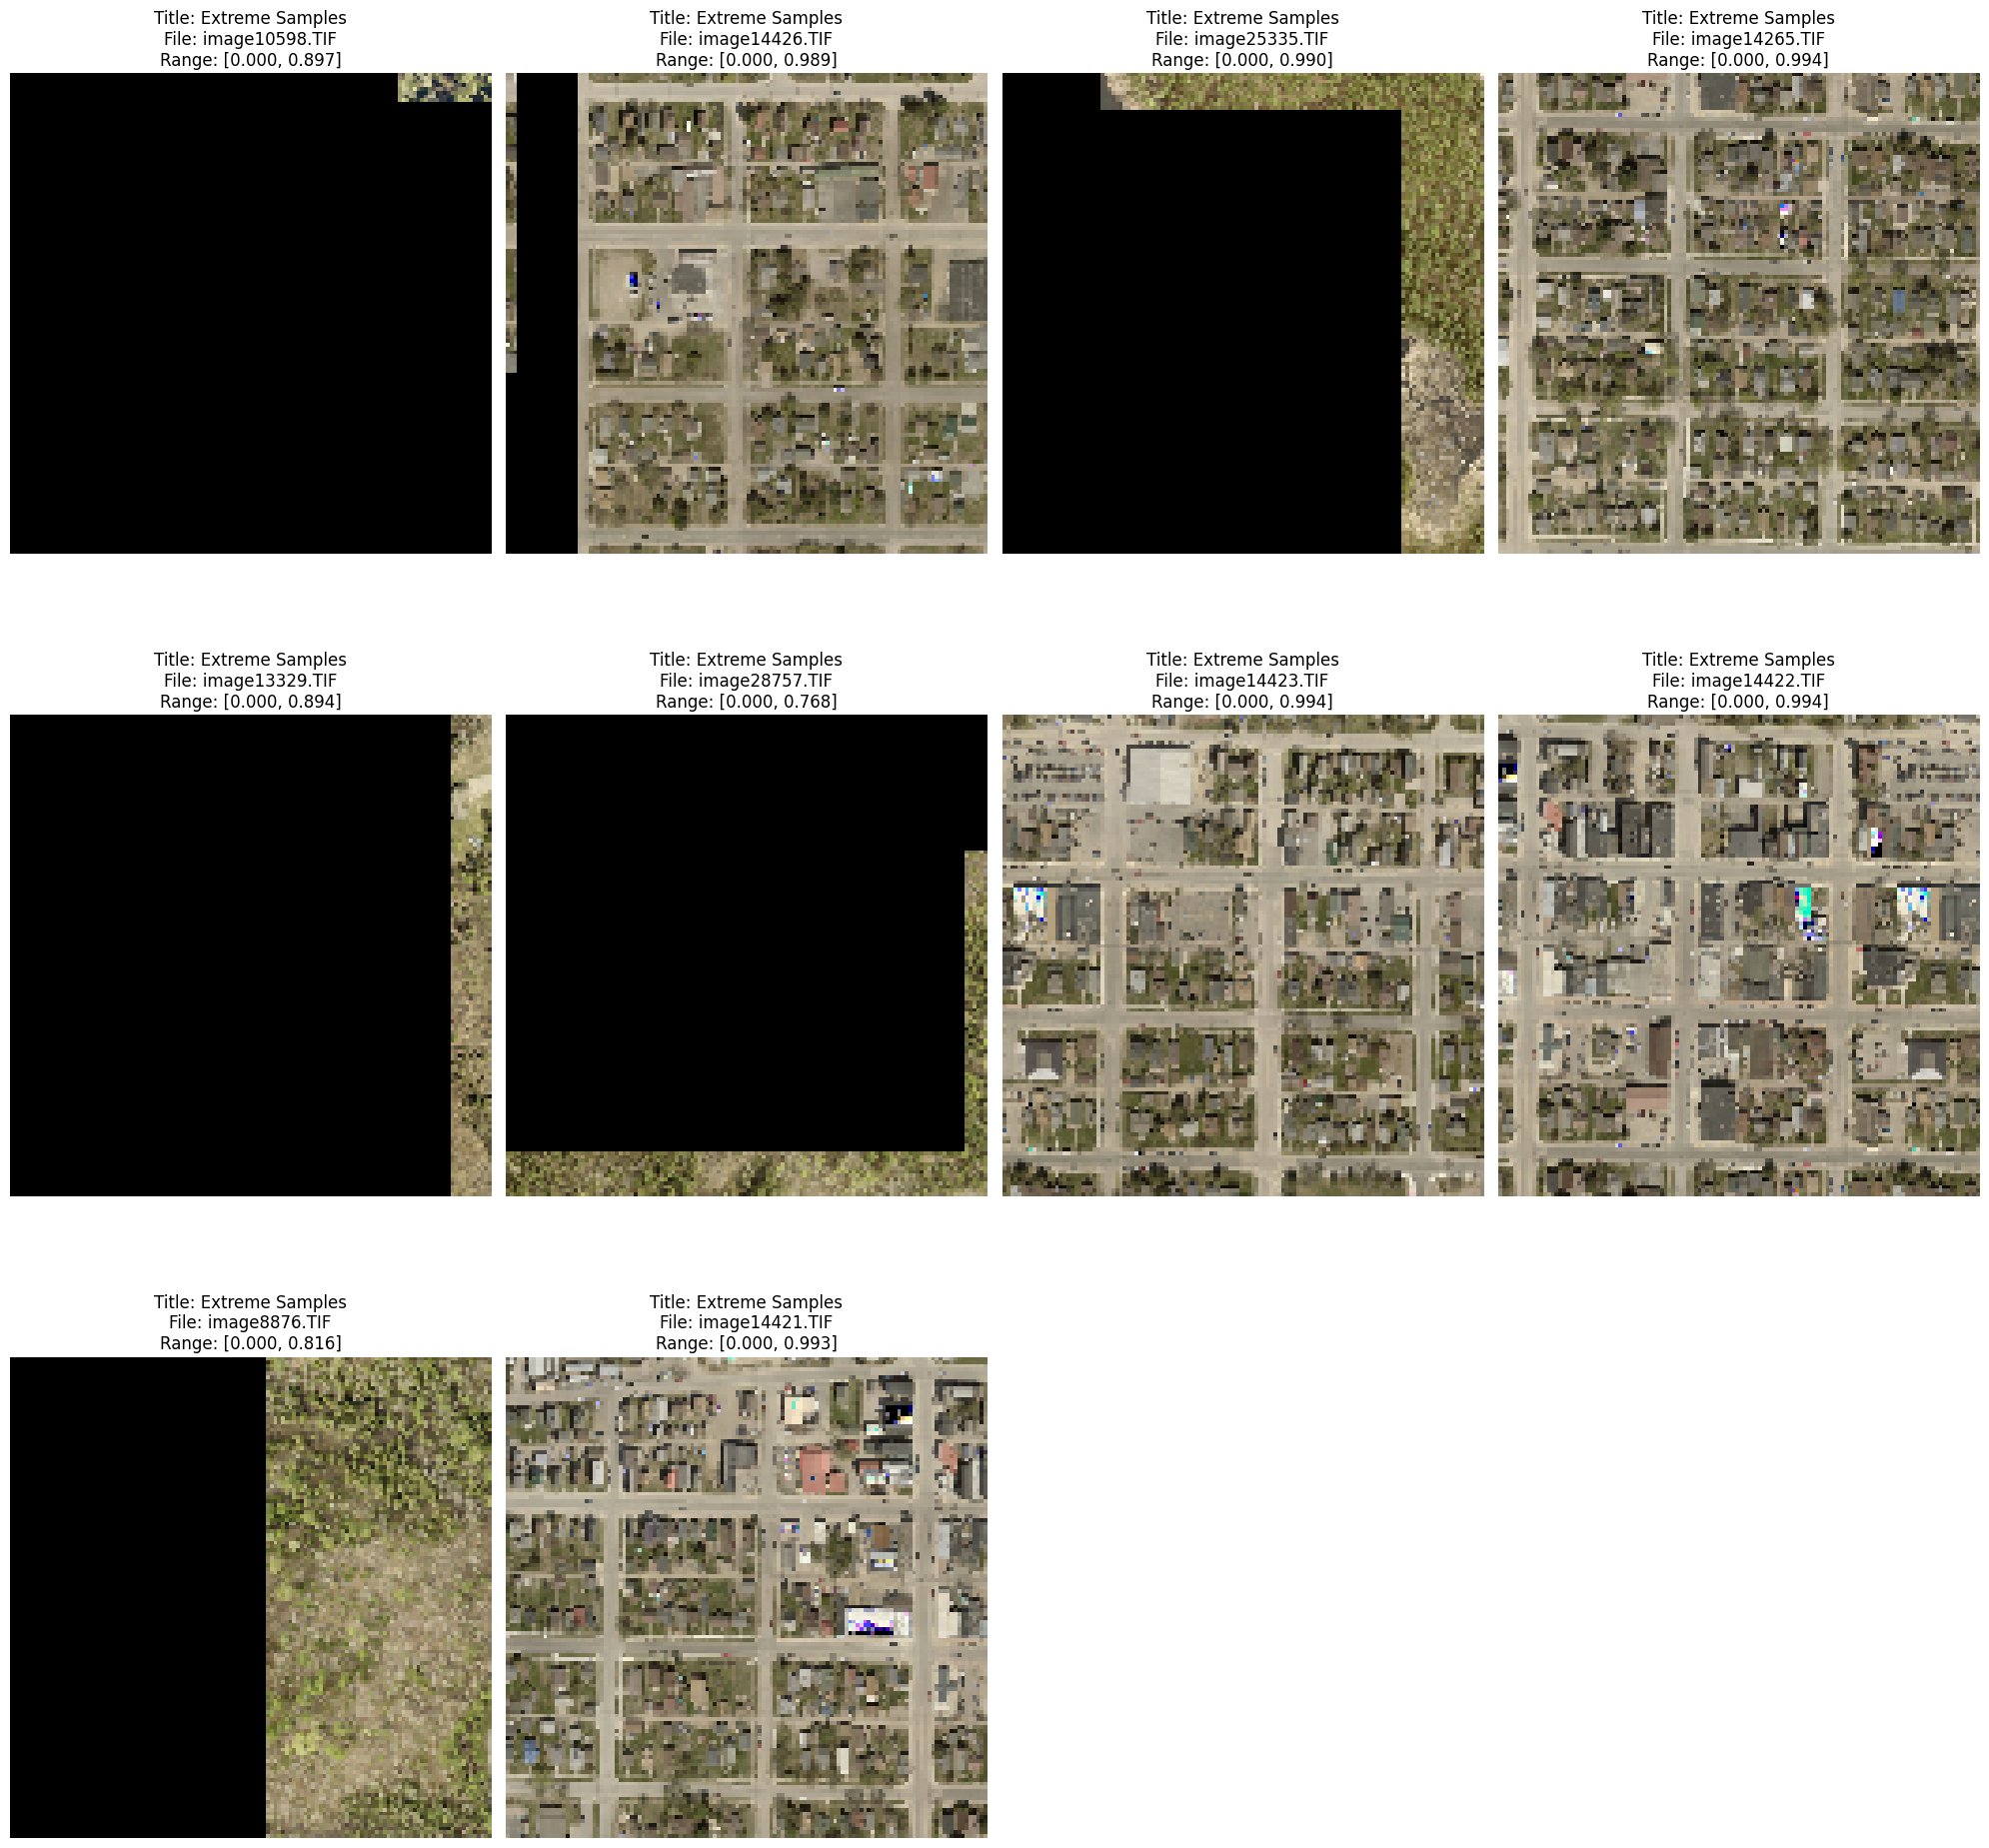

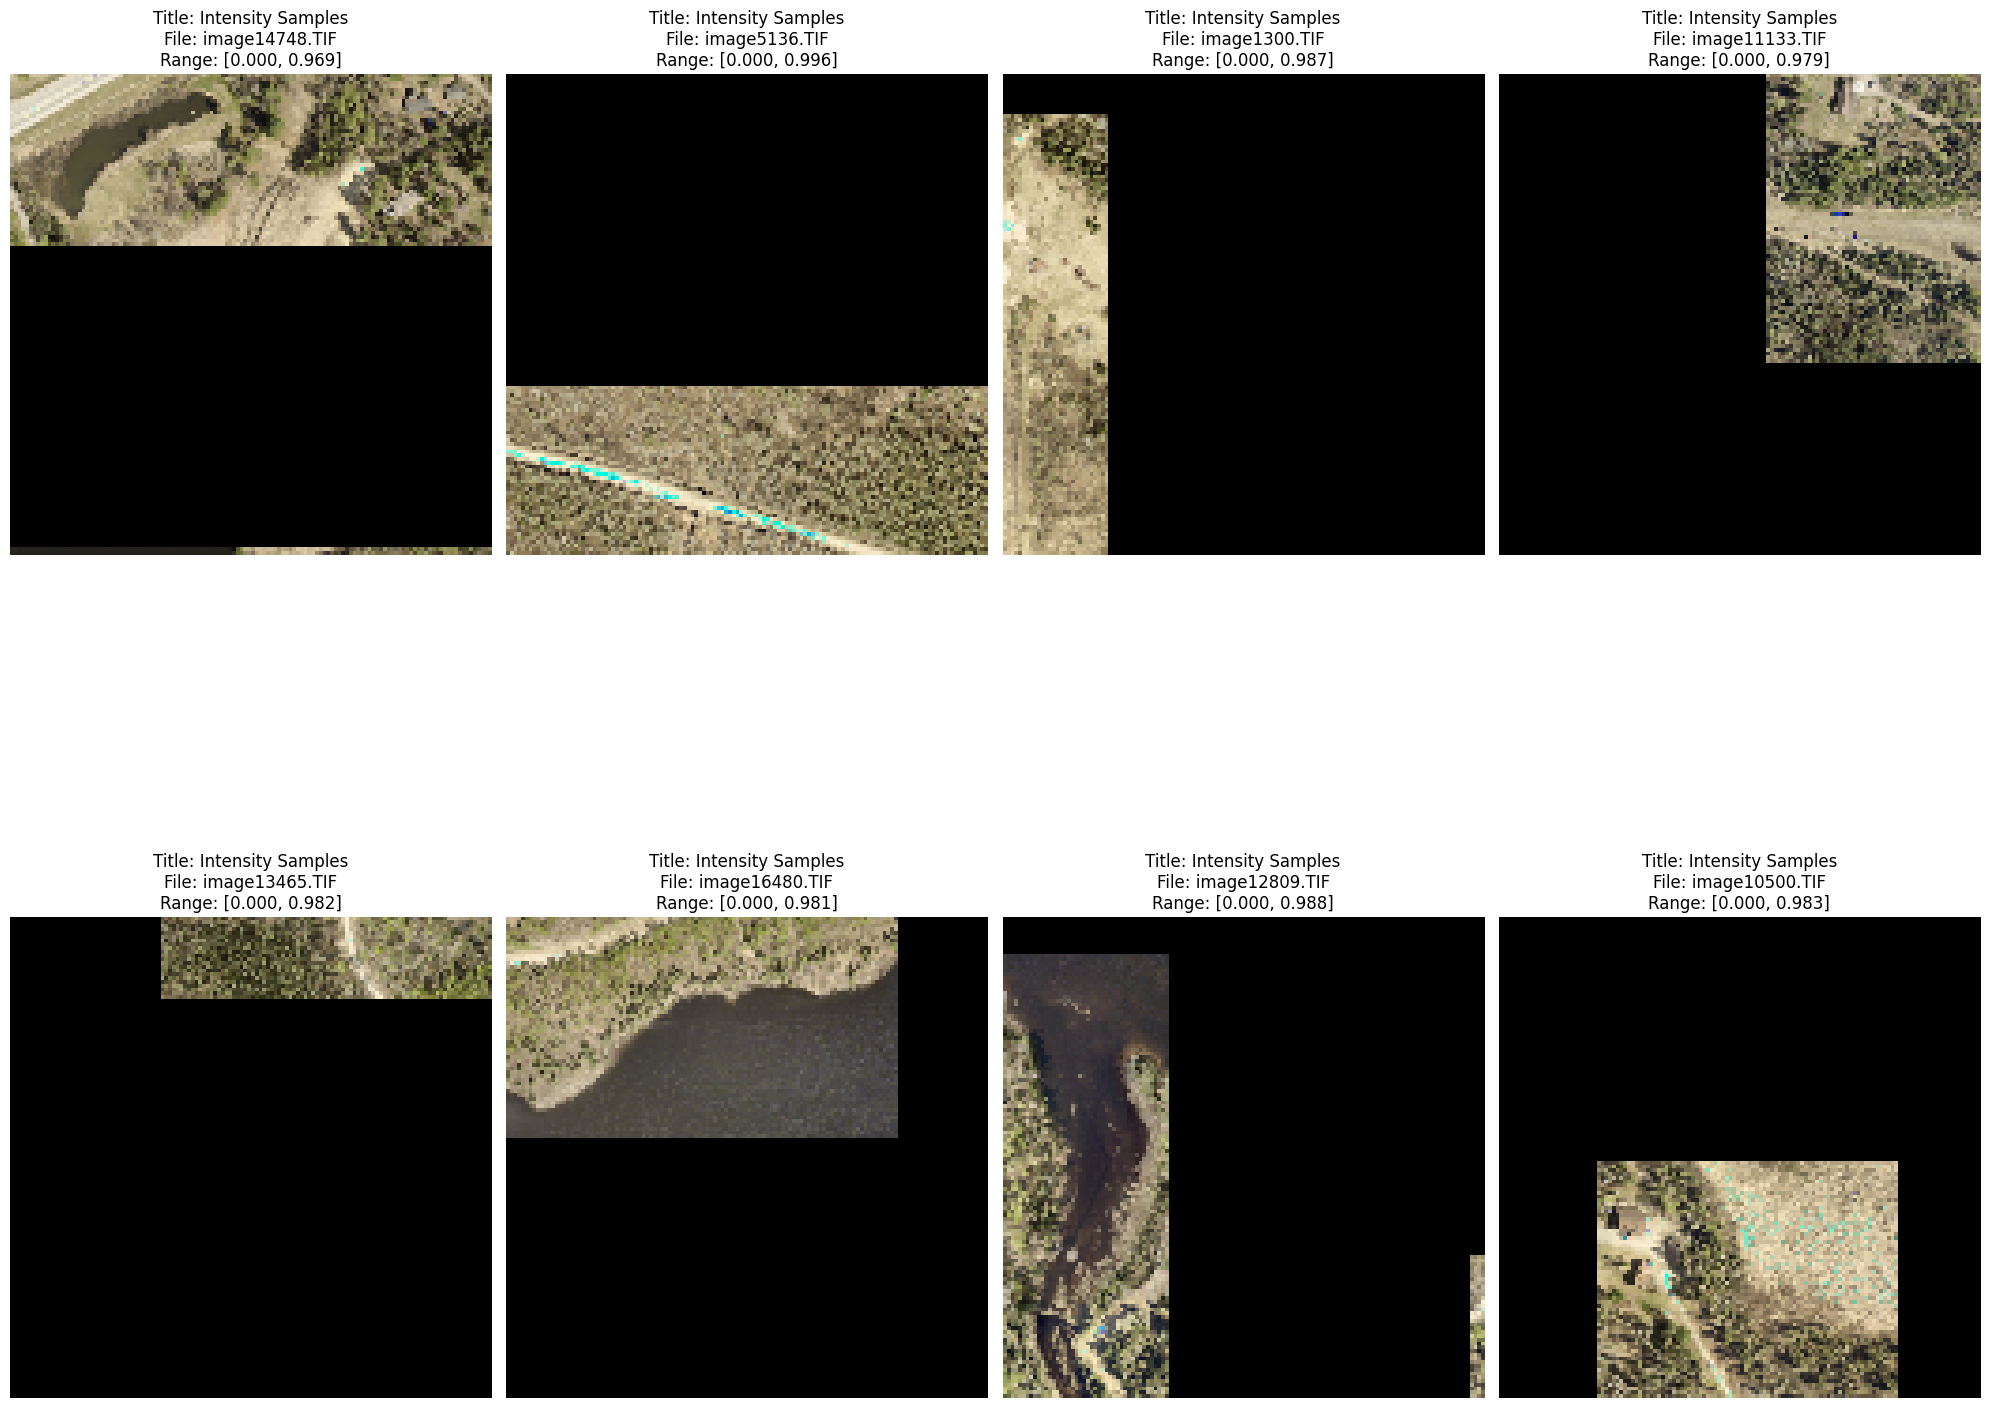

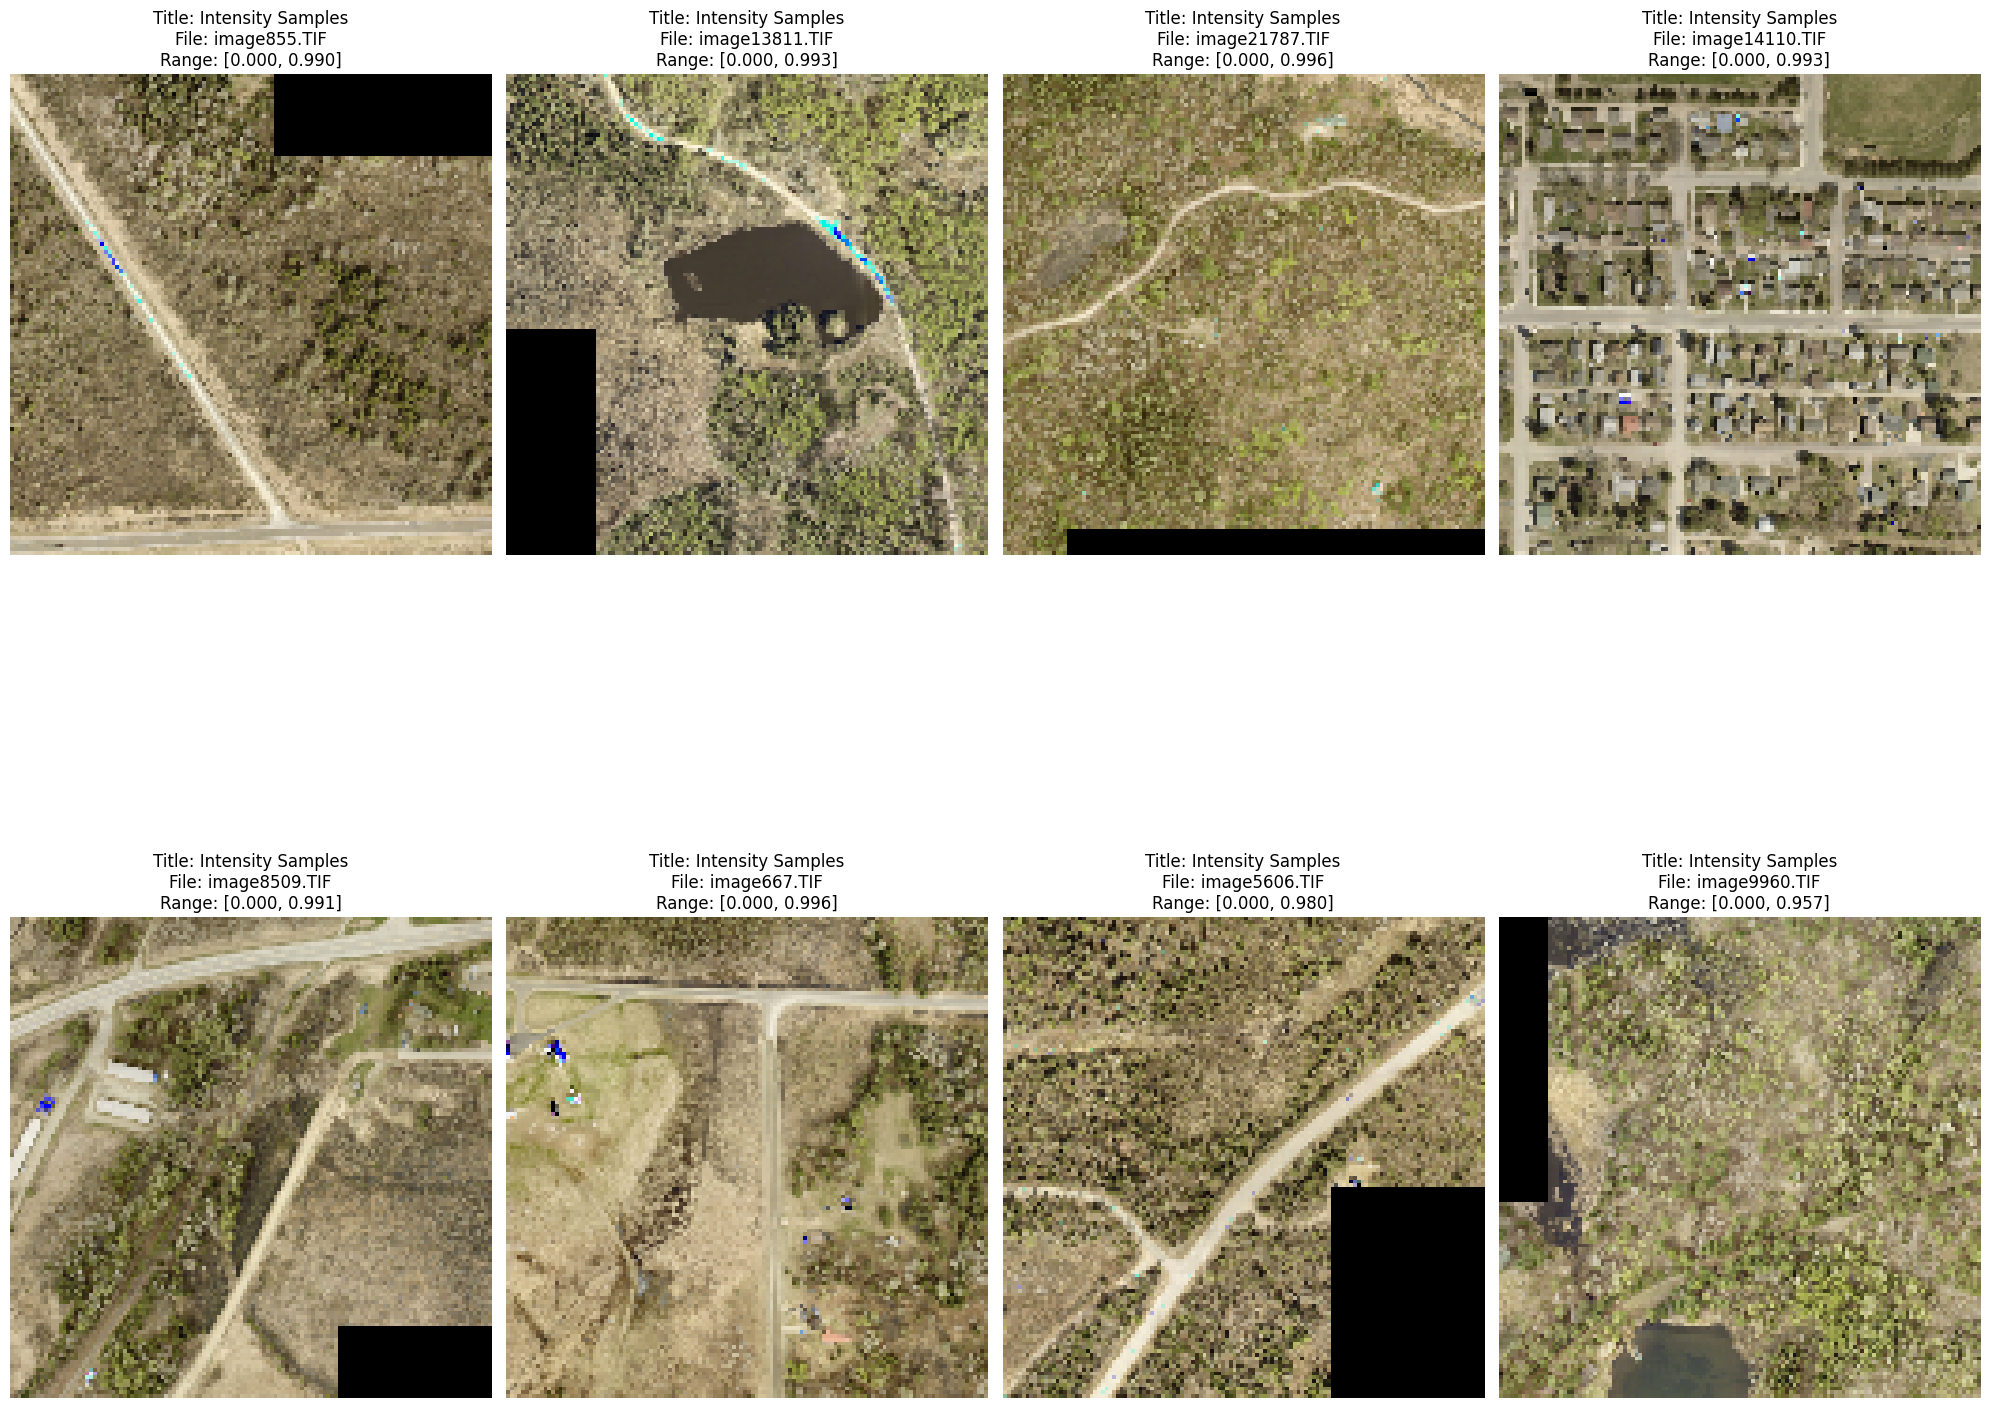

INFO:__main__:
Dataset Analysis:
INFO:__main__:Total number of images: 3482
INFO:__main__:Image shape: (128, 128, 3)
INFO:__main__:Mask shape: (128, 128, 1)
INFO:__main__:
Mask statistics:
INFO:__main__:Average mask coverage: 2.65%
INFO:__main__:Min coverage: 0.00%
INFO:__main__:Max coverage: 17.94%
INFO:__main__:
Per-channel statistics:
INFO:__main__:Channel 0:
INFO:__main__:  Mean: 0.344 ± 0.132
INFO:__main__:  Std:  0.260 ± 0.050
INFO:__main__:  Range: [0.001, 0.971]
INFO:__main__:Channel 1:
INFO:__main__:  Mean: 0.323 ± 0.123
INFO:__main__:  Std:  0.244 ± 0.046
INFO:__main__:  Range: [0.002, 0.952]
INFO:__main__:Channel 2:
INFO:__main__:  Mean: 0.235 ± 0.092
INFO:__main__:  Std:  0.192 ± 0.034
INFO:__main__:  Range: [0.002, 0.888]
INFO:__main__:
Samples with highest mask coverage:
INFO:__main__:File: image14426.TIF, Coverage: 17.16%
INFO:__main__:File: image14265.TIF, Coverage: 17.32%
INFO:__main__:File: image14423.TIF, Coverage: 17.50%
INFO:__main__:File: image14421.TIF, Coverage:

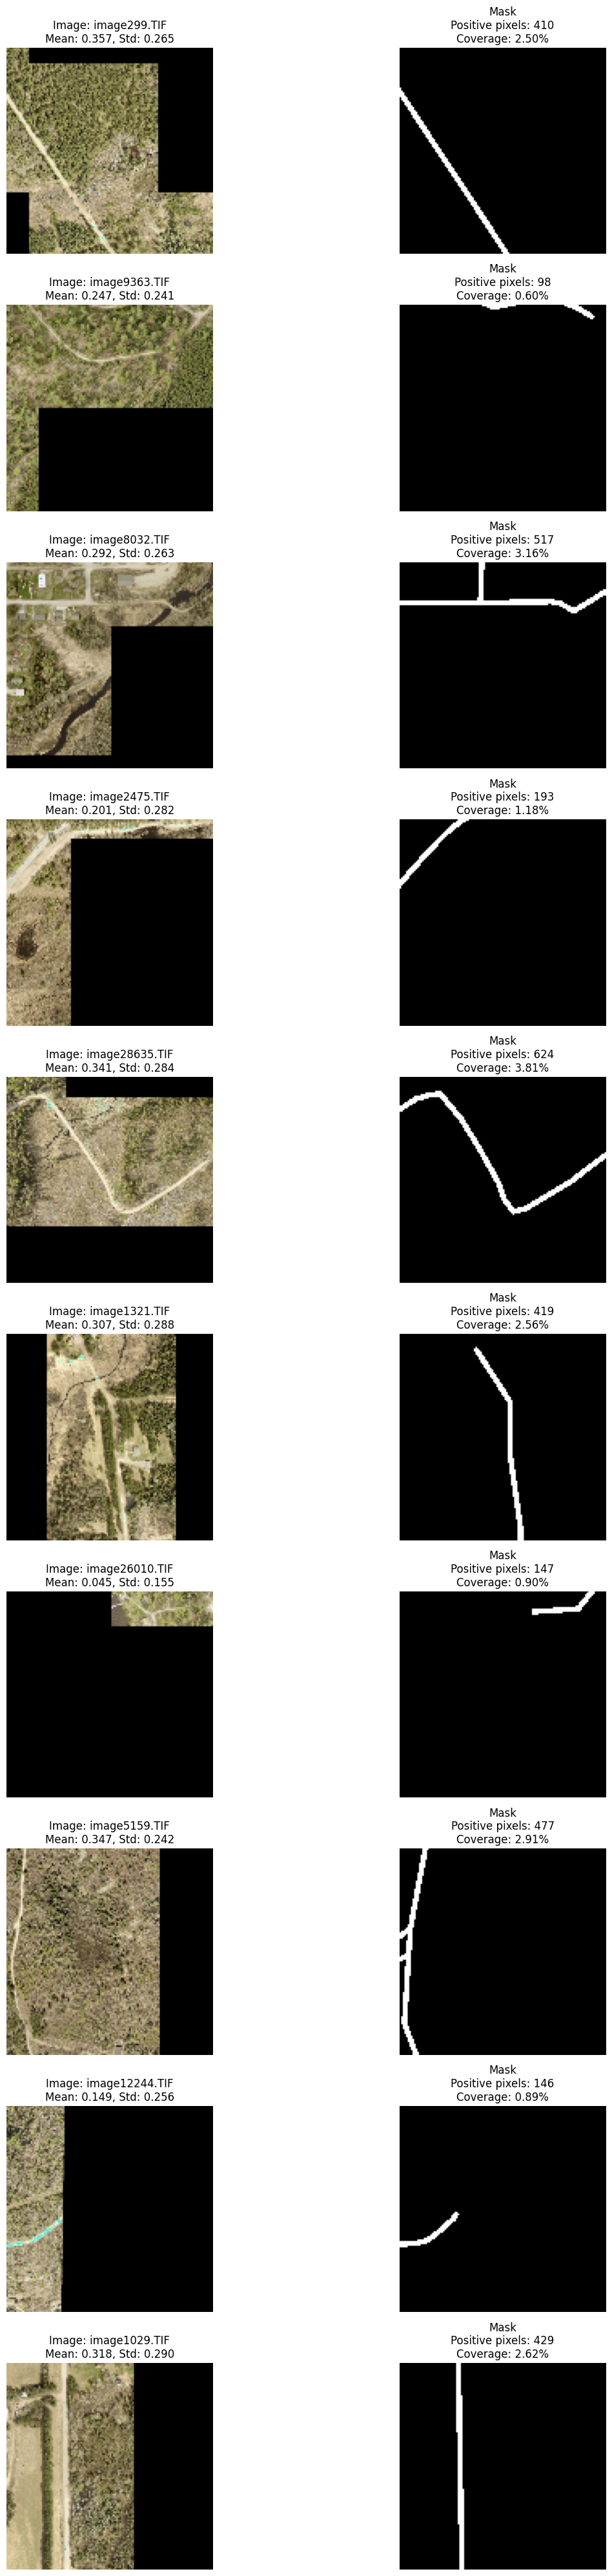

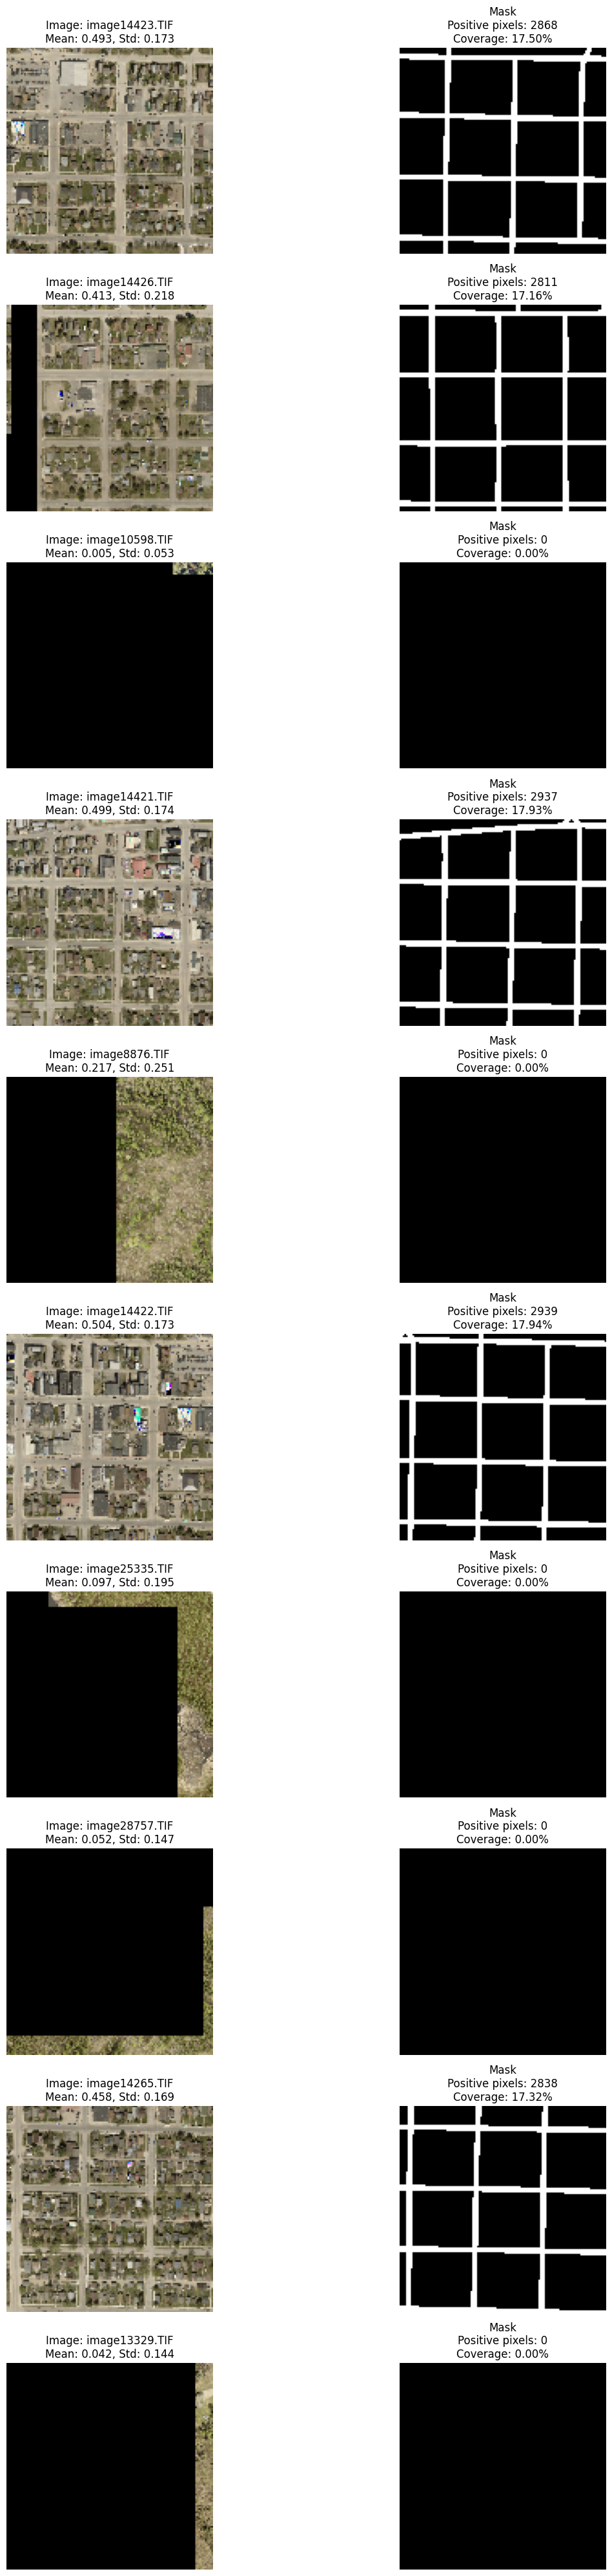

In [ ]:
extreme_indices = analyze_dataset(X, y, file_paths)

visualize_samples(X, file_paths, title = "Random Samples", num_samples=16, save_path='/app/plots/random_samples.png')

extreme_samples = X[extreme_indices]
extreme_files = [file_paths[i] for i in extreme_indices]
visualize_samples(extreme_samples, extreme_files, title = "Extreme Samples", num_samples=len(extreme_indices), 
                    save_path='/app/plots/extreme_samples.png')

low_intensity = np.where(np.mean(X, axis=(1,2,3)) < 0.2)[0]
mid_intensity = np.where((np.mean(X, axis=(1,2,3)) >= 0.4) & 
                        (np.mean(X, axis=(1,2,3)) <= 0.6))[0]
high_intensity = np.where(np.mean(X, axis=(1,2,3)) > 0.8)[0]

for intensity, name in [(low_intensity, 'low'), 
                        (mid_intensity, 'mid'), 
                        (high_intensity, 'high')]:
    if len(intensity) > 0:
        indices = np.random.choice(intensity, min(8, len(intensity)), replace=False)
        samples = X[indices]
        sample_files = [file_paths[i] for i in indices]
        visualize_samples(samples, sample_files, title = "Intensity Samples", 
                        num_samples=len(indices),
                        save_path=f'/app/plots/{name}_intensity_samples.png')
        
interesting_indices = analyze_dataset(X, y, file_paths)

visualize_samples_with_masks(X, y, file_paths, num_samples=10, 
                            save_path='/app/plots/random_samples_with_masks.png')

interesting_samples = X[interesting_indices]
interesting_masks = y[interesting_indices]
interesting_files = [file_paths[i] for i in interesting_indices]
visualize_samples_with_masks(interesting_samples, interesting_masks, interesting_files,
                            num_samples=len(interesting_indices), 
                            save_path='/app/plots/interesting_samples_with_masks.png')

### Model Components

In [ ]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))
        
        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + tf.keras.backend.epsilon())

    def reset_state(self):
        self.intersection.assign(0)
        self.union.assign(0)

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

class AverageMetric(tf.keras.metrics.Metric):
    """Base class for averaging metrics over epochs"""
    def __init__(self, name):
        super().__init__(name=name)
        self.values = self.add_weight(name='values', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, value):
        self.values.assign_add(value)
        self.count.assign_add(1.0)

    def result(self):
        return self.values / (self.count + tf.keras.backend.epsilon())

    def reset_state(self):
        self.values.assign(0.0)
        self.count.assign(0.0)

class AverageF1(AverageMetric):
    def __init__(self):
        super().__init__('avg_f1')

class AverageIoU(AverageMetric):
    def __init__(self):
        super().__init__('avg_iou')

class MetricsLoggerCallback(tf.keras.callbacks.Callback):
    """Custom callback to log average metrics to TensorBoard"""
    def __init__(self, log_dir):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir + '/metrics')
        self.avg_f1 = AverageF1()
        self.avg_iou = AverageIoU()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        self.avg_f1.update_state(logs.get('f1_score', 0))
        self.avg_iou.update_state(logs.get('iou', 0))
        
        with self.writer.as_default():
            tf.summary.scalar('average_f1_score', self.avg_f1.result(), step=epoch)
            tf.summary.scalar('average_iou', self.avg_iou.result(), step=epoch)
            
            if 'val_f1_score' in logs:
                tf.summary.scalar('val_average_f1_score', logs['val_f1_score'], step=epoch)
            if 'val_iou' in logs:
                tf.summary.scalar('val_average_iou', logs['val_iou'], step=epoch)

Blocks and ResUNet Architecture from Road Extraction by Deep Residual U-Net by Zhang et al. 

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

def ResUNet(input_size=(128, 128, 3)):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(input_size)
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
def create_segmentation_model(input_shape=(128, 128, 3)):
    model = ResUNet(input_shape)
    
   
    initial_learning_rate = 1e-6
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=initial_learning_rate,
        clipnorm=1.0,  
        epsilon=1e-7   
    )
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    def stable_dice_loss(y_true, y_pred):
        smooth = 1e-7
        
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice
    
    def stable_bce(y_true, y_pred):
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        bce = tf.reduce_mean(
            -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        )
        return bce
    
    def combined_loss(y_true, y_pred):
        dice = stable_dice_loss(y_true, y_pred)
        bce = stable_bce(y_true, y_pred)
        return 0.5 * bce + 0.5 * dice
    
    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[
            IoU(threshold=0.5, name='iou'),
            F1Score(threshold=0.5, name='f1_score'),
            'accuracy'
        ]
    )
    
    return model

def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=100):
    os.makedirs('/app/logs', exist_ok=True)
    os.makedirs('/app/models', exist_ok=True)
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            '/app/models/model-{epoch:02d}-{val_iou:.3f}.h5',
            monitor='val_iou',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_iou',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_iou',
            patience=10,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir='/app/logs/',
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            update_freq='epoch'
        ),
        MetricsLoggerCallback('/app/logs/')
    ]
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [ ]:
def visualize_predictions(model, images, masks, file_paths, num_samples=5, save_path='/app/plots'):
    plt.close('all')
    
    rows = num_samples
    cols = 3
    
    fig = plt.figure(figsize=(15, 5*num_samples))
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    predictions = model.predict(images[indices])
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, 3*i + 1)
        plt.imshow(images[idx])
        plt.title(f'Image: {Path(file_paths[idx]).name}')
        plt.axis('off')
        
        plt.subplot(rows, cols, 3*i + 2)
        plt.imshow(masks[idx, ..., 0], cmap='gray')
        true_coverage = np.mean(masks[idx]) * 100
        plt.title(f'True Mask\nCoverage: {true_coverage:.1f}%')
        plt.axis('off')
        
        plt.subplot(rows, cols, 3*i + 3)
        plt.imshow(predictions[i, ..., 0], cmap='gray')
        pred_coverage = np.mean(predictions[i] > 0.5) * 100
        iou = compute_iou(masks[idx], predictions[i] > 0.5)
        plt.title(f'Predicted Mask\nCoverage: {pred_coverage:.1f}%\nIoU: {iou:.3f}')
        plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        logger.info(f"Saved visualization to {save_path}")
    
    plt.close(fig)

def compute_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum((y_true + y_pred) > 0)
    return intersection / (union + 1e-7)

def visualize_results(model, X_val, y_val, file_paths, num_samples=5):
    plt.close('all')
    
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    
    predictions = model.predict(X_val[indices])
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for idx, (img, mask, pred, file_path) in enumerate(zip(X_val[indices], 
                                                          y_val[indices], 
                                                          predictions, 
                                                          [file_paths[i] for i in indices])):
        # Original image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Image: {Path(file_path).name}')
        axes[idx, 0].axis('off')
        
        # True mask
        axes[idx, 1].imshow(mask[..., 0], cmap='gray')
        axes[idx, 1].set_title(f'True Mask\nCoverage: {100*np.mean(mask):.1f}%')
        axes[idx, 1].axis('off')
        
        # Predicted mask
        axes[idx, 2].imshow(pred[..., 0], cmap='gray')
        iou = compute_iou(mask, (pred > 0.5).astype(np.float32))
        axes[idx, 2].set_title(f'Predicted Mask\nIoU: {iou:.3f}')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('/app/plots/validation_results.png')
    plt.close()

def plot_training_history(history):
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(history.history['loss'], label='Training')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    # IoU
    ax2.plot(history.history['iou'], label='Training')
    ax2.plot(history.history['val_iou'], label='Validation')
    ax2.set_title('IoU')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('/app/plots/training_history.png')
    plt.close()

def plot_metrics(history):
    metrics = ['loss', 'iou', 'f1_score', 'accuracy', 'avg_iou', 'avg_f1']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Training {metric}')
        
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')
            
        plt.title(f'{metric.capitalize()} Over Time')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('/app/plots/training_metrics.png')
    plt.close()

### Callbacks

In [ ]:
def setup_logging():
    log_dir = "/app/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    return tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=2,
        embeddings_freq=1
    )

### Training

#### Params

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100

X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
logger.info(f"Training set: {X_train.shape}, {y_train.shape}")
logger.info(f"Validation set: {X_val.shape}, {y_val.shape}")

model = create_segmentation_model(input_shape=IMAGE_SIZE + (3,))
model.summary()

INFO:__main__:Training set: (2785, 128, 128, 3), (2785, 128, 128, 1)
INFO:__main__:Validation set: (697, 128, 128, 3), (697, 128, 128, 1)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_120 (Conv2D)         (None, 128, 128, 16)         448       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_112 (B  (None, 128, 128, 16)         64        ['conv2d_120[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_76 (Activation)  (None, 128, 128, 16)         0         ['batch_normalization_11

#### Fit

In [ ]:
logger.info("Starting training...")
try:
    history = train_model(
        model, 
        X_train, y_train,
        X_val, y_val,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
    )
    
    plot_training_history(history)
    
    logger.info("Generating validation visualizations...")
    visualize_results(model, X_val, y_val, file_paths)
    
    model.save('app/models/final_model.h5')
    logger.info("Training completed successfully!")
    
    final_val_iou = history.history['val_iou'][-1]
    final_val_loss = history.history['val_loss'][-1]
    logger.info(f"Final validation IoU: {final_val_iou:.4f}")
    logger.info(f"Final validation loss: {final_val_loss:.4f}")
    
    logger.info("Evaluating on validation set...")
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    metrics = dict(zip(model.metrics_names, eval_results))
    
    for metric_name, value in metrics.items():
        logger.info(f"Validation {metric_name}: {value:.4f}")
    
except Exception as e:
    logger.error(f"Training failed: {str(e)}")
    raise

INFO:__main__:Starting training...


Epoch 1/100
175/175 [==============================] - 17s 59ms/step - loss: nan - iou: 0.0429 - f1_score: 0.0823 - accuracy: 0.5912 - val_loss: nan - val_iou: 0.0313 - val_f1_score: 0.0606 - val_accuracy: 0.8317 - lr: 1.0000e-05
Epoch 2/100
175/175 [==============================] - 6s 34ms/step - loss: nan - iou: 0.0438 - f1_score: 0.0839 - accuracy: 0.5900 - val_loss: nan - val_iou: 0.0282 - val_f1_score: 0.0549 - val_accuracy: 0.7744 - lr: 1.0000e-05
Epoch 3/100
175/175 [==============================] - 6s 35ms/step - loss: nan - iou: 0.0451 - f1_score: 0.0864 - accuracy: 0.5881 - val_loss: nan - val_iou: 0.0393 - val_f1_score: 0.0756 - val_accuracy: 0.6891 - lr: 1.0000e-05
Epoch 4/100
175/175 [==============================] - 6s 35ms/step - loss: nan - iou: 0.0470 - f1_score: 0.0897 - accuracy: 0.5885 - val_loss: nan - val_iou: 0.0468 - val_f1_score: 0.0894 - val_accuracy: 0.6222 - lr: 1.0000e-05
Epoch 5/100
175/175 [==============================] - 6s 35ms/step - loss: nan - i

INFO:__main__:Generating validation visualizations...


1/1 [==============================] - 0s 267ms/step


INFO:__main__:Training completed successfully!
INFO:__main__:Final validation IoU: 0.1376
INFO:__main__:Final validation loss: nan
INFO:__main__:Evaluating on validation set...
INFO:__main__:Validation loss: nan
INFO:__main__:Validation iou: 0.1403
INFO:__main__:Validation f1_score: 0.2461
INFO:__main__:Validation accuracy: 0.8751


### Inference

In [ ]:
def predict_mask(model, image_path, image_size=(128, 128)):
    img, _ = load_geotiff(image_path)
    if img is None:
        return None
    
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32)
    
    img = tf.expand_dims(img, 0)
    
    pred = model.predict(img)
    
    mask = (pred[0, ..., 0] > 0.5).astype(np.float32)
    
    return mask

def batch_predict(model, image_paths, image_size=(128, 128), batch_size=32):
    predictions = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        
        for path in batch_paths:
            img, _ = load_geotiff(path)
            if img is not None:
                img = tf.image.resize(img, image_size)
                img = tf.cast(img, tf.float32)
                batch_images.append(img)
        
        if batch_images:
            batch_images = np.stack(batch_images)
            batch_preds = model.predict(batch_images)
            predictions.extend((batch_preds > 0.5).astype(np.float32))
    
    return predictions